In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.metrics import binary_accuracy
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
print("Tensorflow", tf.__version__)


Tensorflow 2.2.0


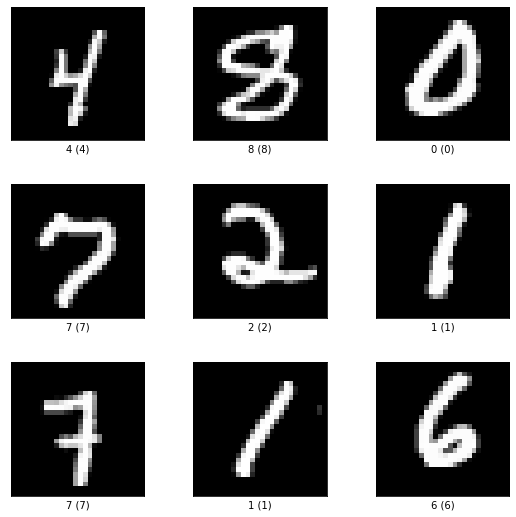

In [2]:
ds_train, ds_info = tfds.load('mnist', split='train', shuffle_files=True, with_info=True)
fig = tfds.show_examples(ds_info, ds_train)


In [3]:
batch_size = 128
image_shape = (32, 32, 1)

def preprocess(features):
    image = tf.image.resize(features['image'], image_shape[:2])    
    image = tf.cast(image, tf.float32)
    image = (image-127.5)/127.5
    return image


ds_train = ds_train.map(preprocess)
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size, drop_remainder=True).repeat()

train_num = ds_info.splits['train'].num_examples
train_steps_per_epoch = round(train_num/batch_size)
print(train_steps_per_epoch)

469


In [4]:
class WGAN():
    def __init__(self, input_shape):

        self.z_dim = 128
        self.input_shape = input_shape
        
        # losses
        self.loss_critic_real = {}
        self.loss_critic_fake = {}
        self.loss_critic = {}
        self.loss_generator = {}
        
        # critic
        self.n_critic = 5
        self.critic = self.build_critic()
        self.critic.trainable = False

        self.optimizer_critic = RMSprop(5e-5)

        # build generator pipeline with frozen critic
        self.generator = self.build_generator()
        critic_output = self.critic(self.generator.output)
        self.model = Model(self.generator.input, critic_output)
        self.model.compile(loss = self.wasserstein_loss,
                           optimizer =  RMSprop(5e-5))
        self.critic.trainable = True

        
    def wasserstein_loss(self, y_true, y_pred):

        w_loss = -tf.reduce_mean(y_true*y_pred)

        return w_loss

    def build_generator(self):

        DIM = 128
        model = tf.keras.Sequential(name='Generator') 

        model.add(layers.Input(shape=[self.z_dim])) 

        model.add(layers.Dense(4*4*4*DIM))
        model.add(layers.BatchNormalization()) 
        model.add(layers.ReLU())
        model.add(layers.Reshape((4,4,4*DIM))) 

        model.add(layers.UpSampling2D((2,2), interpolation="bilinear"))
        model.add(layers.Conv2D(2*DIM, 5, padding='same')) 
        model.add(layers.BatchNormalization()) 
        model.add(layers.ReLU())

        model.add(layers.UpSampling2D((2,2), interpolation="bilinear"))
        model.add(layers.Conv2D(DIM, 5, padding='same')) 
        model.add(layers.BatchNormalization()) 
        model.add(layers.ReLU())

        model.add(layers.UpSampling2D((2,2), interpolation="bilinear"))       
        model.add(layers.Conv2D(image_shape[-1], 5, padding='same', activation='tanh')) 

        return model             
    
    def build_critic(self):

        DIM = 128
        model = tf.keras.Sequential(name='critics') 

        model.add(layers.Input(shape=self.input_shape)) 

        model.add(layers.Conv2D(1*DIM, 5, strides=2, padding='same'))
        model.add(layers.LeakyReLU(0.2))

        model.add(layers.Conv2D(2*DIM, 5, strides=2, padding='same'))
        model.add(layers.BatchNormalization()) 
        model.add(layers.LeakyReLU(0.2))

        model.add(layers.Conv2D(4*DIM, 5, strides=2, padding='same'))
        model.add(layers.BatchNormalization()) 
        model.add(layers.LeakyReLU(0.2))


        model.add(layers.Flatten()) 
        model.add(layers.Dense(1)) 

        return model     
    
 
    def train_critic(self, real_images, batch_size):

        real_labels = tf.ones(batch_size)
        fake_labels = -tf.ones(batch_size)
                  
        g_input = tf.random.normal((batch_size, self.z_dim))
        fake_images = self.generator.predict(g_input)
        
        with tf.GradientTape() as total_tape:
            
            # forward pass
            pred_fake = self.critic(fake_images)
            pred_real = self.critic(real_images)
            
            # calculate losses
            loss_fake = self.wasserstein_loss(fake_labels, pred_fake)
            loss_real = self.wasserstein_loss(real_labels, pred_real)           

            # total loss
            total_loss = loss_fake + loss_real
            
            # apply gradients
            gradients = total_tape.gradient(total_loss, self.critic.trainable_variables)
            
            self.optimizer_critic.apply_gradients(zip(gradients, self.critic.trainable_variables))

        for layer in self.critic.layers: 
            weights = layer.get_weights() 
            weights = [tf.clip_by_value(w, -0.01, 0.01) for w in weights]
            layer.set_weights(weights) 

        return loss_fake, loss_real
                                                
    def train(self, data_generator, batch_size, steps, interval=200):

        val_g_input = tf.random.normal((batch_size, self.z_dim))
        real_labels = tf.ones(batch_size)

        for i in range(steps):
            for _ in range(self.n_critic):
                real_images = next(data_generator)
                loss_fake, loss_real = self.train_critic(real_images, batch_size)
                critic_loss = loss_fake + loss_real
                
            # train generator
            g_input = tf.random.normal((batch_size, self.z_dim))
            g_loss = self.model.train_on_batch(g_input, real_labels)
            
            self.loss_critic_real[i] = loss_real.numpy()
            self.loss_critic_fake[i] = loss_fake.numpy()
            self.loss_critic[i] = critic_loss.numpy()
            self.loss_generator[i] = g_loss

            if i%interval == 0:
                msg = "Step {}: g_loss {:.4f} critic_loss {:.4f} critic fake {:.4f}  critic_real {:.4f}"\
                .format(i, g_loss, critic_loss, loss_fake, loss_real)
                print(msg)

                fake_images = self.generator.predict(val_g_input)
                self.plot_images(fake_images)
                self.plot_losses()

    def plot_images(self, images):   
        grid_row = 1
        grid_col = 8
        f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*2.5, grid_row*2.5))
        for row in range(grid_row):
            for col in range(grid_col):
                if self.input_shape[-1]==1:
                    axarr[col].imshow(images[col,:,:,0]*0.5+0.5, cmap='gray')
                else:
                    axarr[col].imshow(images[col]*0.5+0.5)
                axarr[col].axis('off') 
        plt.show()

    def plot_losses(self):
        fig, (ax1, ax2) = plt.subplots(2, sharex=True)
        fig.set_figwidth(10)
        fig.set_figheight(6)
        ax1.plot(list(self.loss_critic.values()), label='Critic loss', alpha=0.7)
        ax1.set_title("Critic loss")
        ax2.plot(list(self.loss_generator.values()), label='Generator loss', alpha=0.7)
        ax2.set_title("Generator loss")

        plt.xlabel('Steps')
        plt.show()

In [5]:
wgan = WGAN(image_shape)
wgan.generator.summary()


Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              1056768   
_________________________________________________________________
batch_normalization_2 (Batch (None, 8192)              32768     
_________________________________________________________________
re_lu (ReLU)                 (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         3277056   
_________________________________________________________________
batch_normalization_3 (Batch (None, 8, 8, 256)         10

In [6]:
wgan.critic.summary()

Model: "critics"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 128)       3328      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 256)         819456    
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 256)         1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 512)         3277312   
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 512)         2048

Step 0: g_loss -0.0002 critic_loss -0.0005 critic fake 0.0001  critic_real -0.0006


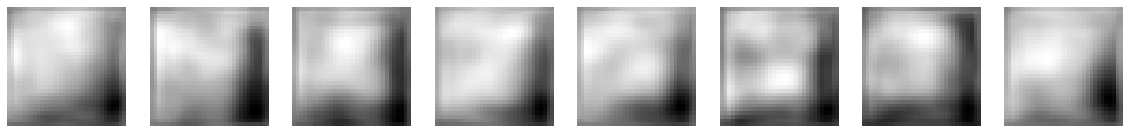

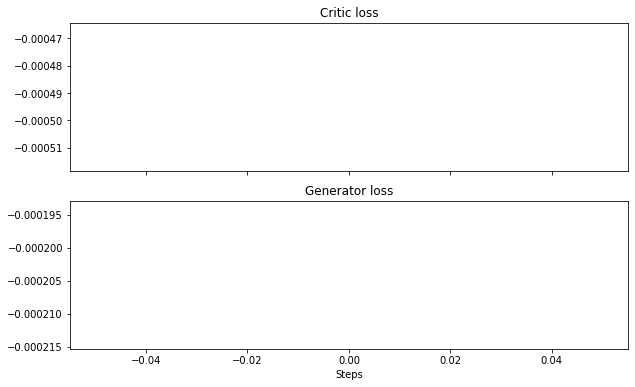

Step 100: g_loss -2.8789 critic_loss -25.8701 critic fake -60.1646  critic_real 34.2945


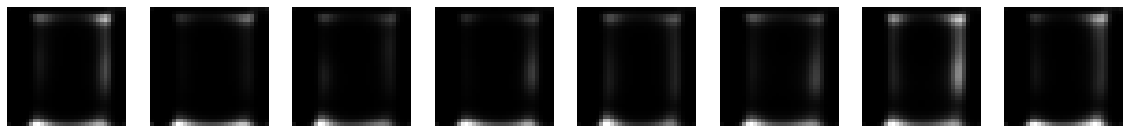

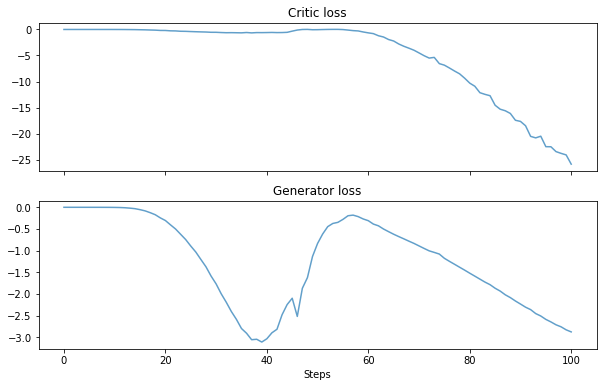

Step 200: g_loss -4.3772 critic_loss 7.4466 critic fake -19.1779  critic_real 26.6245


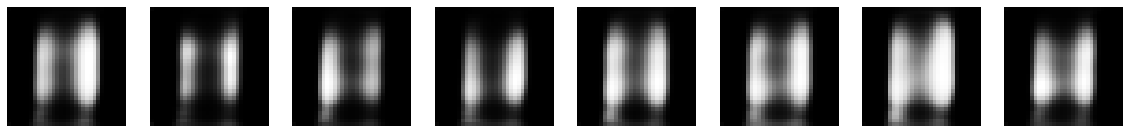

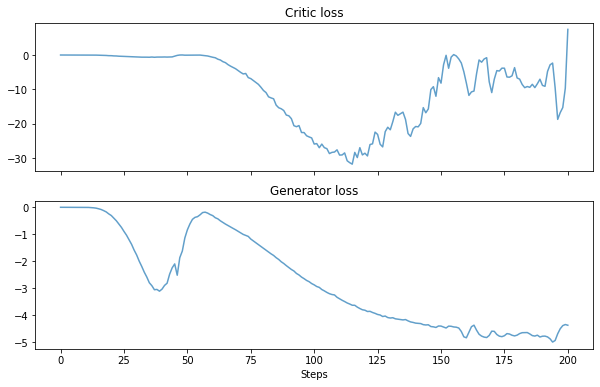

Step 300: g_loss -0.1583 critic_loss -0.0266 critic fake 0.2856  critic_real -0.3122


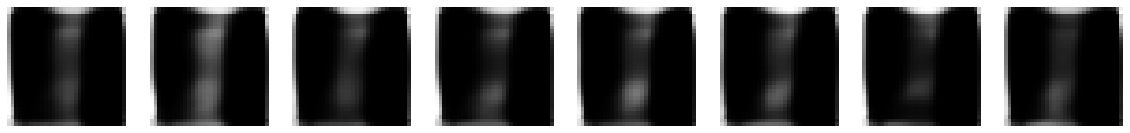

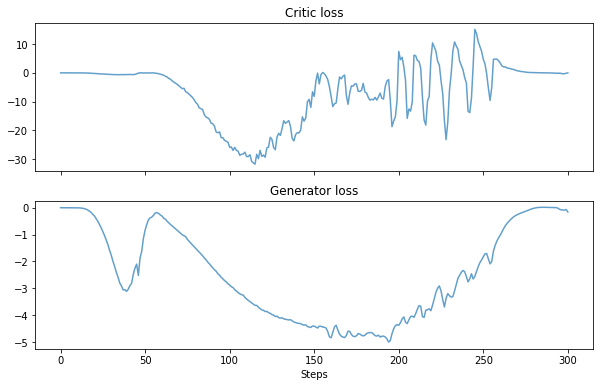

Step 400: g_loss -0.8496 critic_loss 0.1698 critic fake 0.8594  critic_real -0.6895


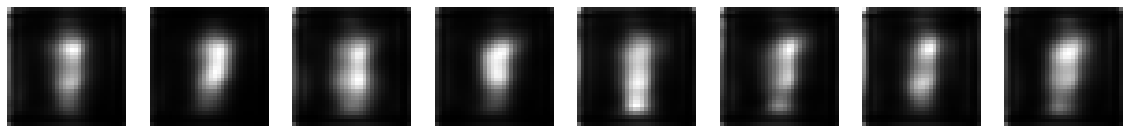

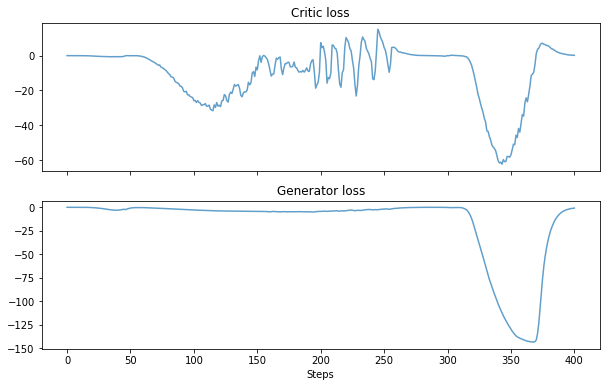

Step 500: g_loss 0.3490 critic_loss -0.1334 critic fake -0.4372  critic_real 0.3038


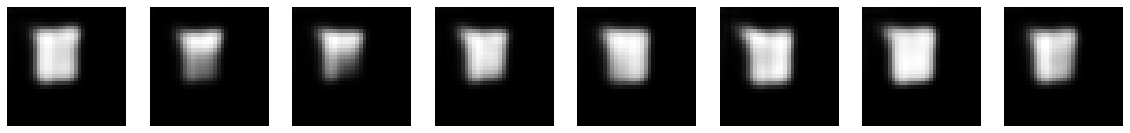

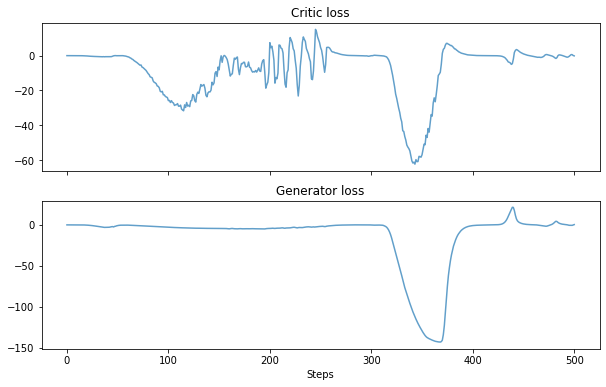

Step 600: g_loss -0.8339 critic_loss 0.0991 critic fake 0.8214  critic_real -0.7223


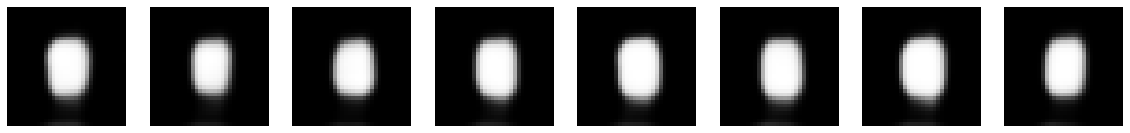

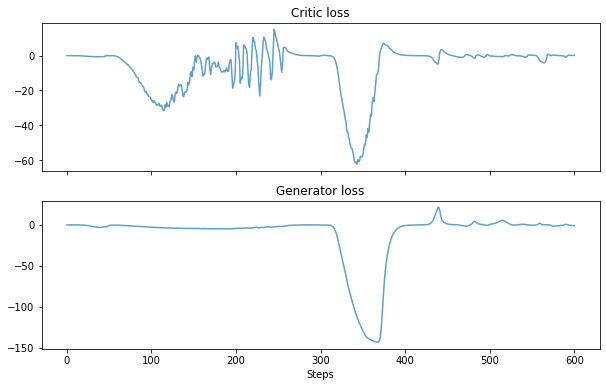

Step 700: g_loss 0.6221 critic_loss 0.0072 critic fake -0.4291  critic_real 0.4363


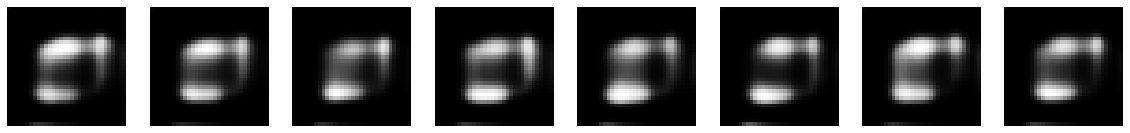

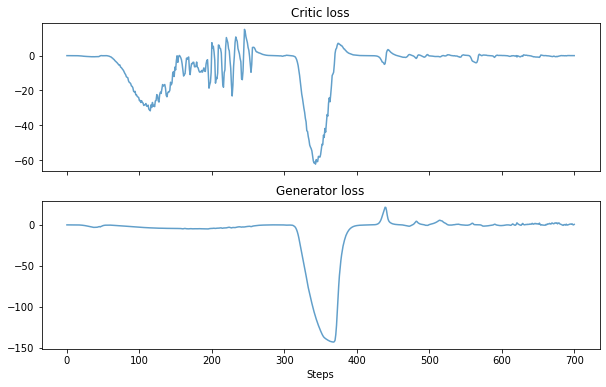

Step 800: g_loss 0.5583 critic_loss -0.0810 critic fake -0.3637  critic_real 0.2827


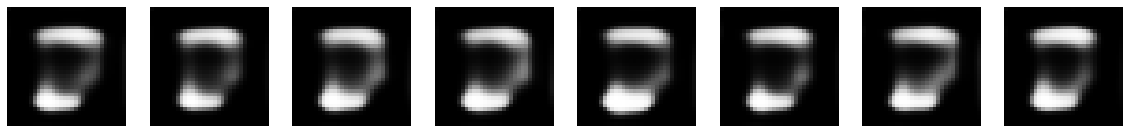

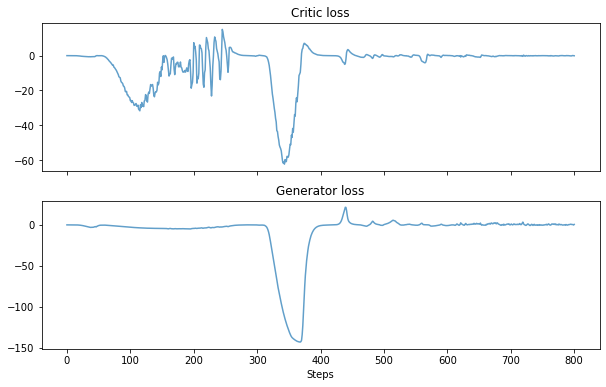

Step 900: g_loss 1.0329 critic_loss -0.3347 critic fake -1.1482  critic_real 0.8135


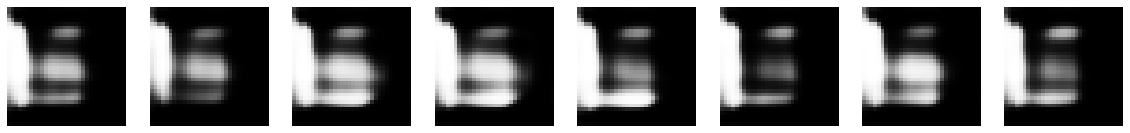

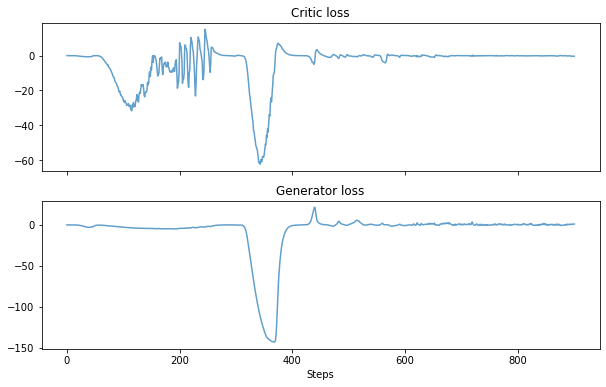

Step 1000: g_loss -0.5530 critic_loss -0.1258 critic fake 0.3879  critic_real -0.5136


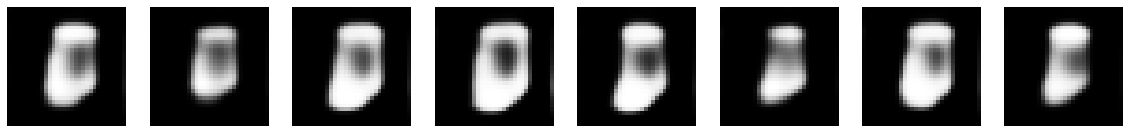

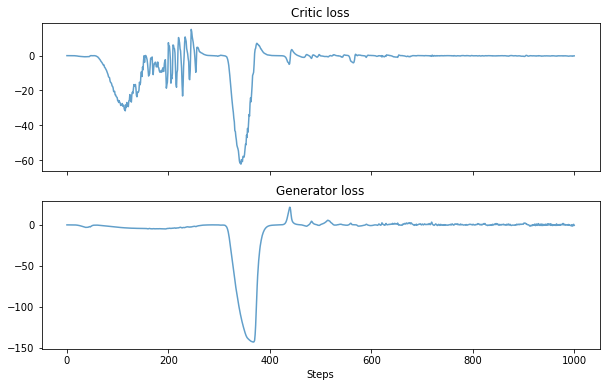

KeyboardInterrupt: 

In [7]:
wgan.train(iter(ds_train), batch_size, 2000, 100)

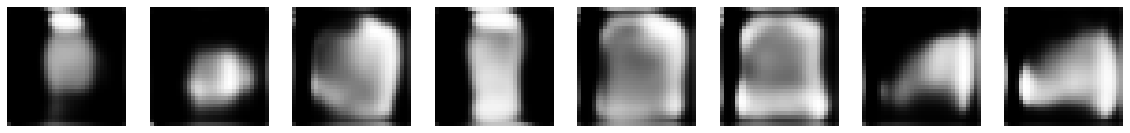

In [16]:
z = tf.random.normal((8, 128))
generated_images = wgan.generator.predict(z)
wgan.plot_images(generated_images)

In [9]:
wgan.generator.save_weights('./models/wgan_fashion_mnist.weights')